<a href="https://colab.research.google.com/github/rawdhikagupta/Texture-Analysis-Model/blob/main/FV_CNN_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install fishervector
import fishervector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fishervector: filename=fishervector-0.1-py3-none-any.whl size=3687 sha256=15ece39d5b0a71c2f97f6b8d40286a3dc0c598c68428b76f3ea14fcda1ca99ce
  Stored in directory: /root/.cache/pip/wheels/7a/e9/ee/299676aacb91bc63542c99b10379386e544a4246af491e1429
Successfully built fishervector


In [ ]:
# load dataset
path = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz'
path_to_file = tf.keras.utils.get_file("dtd-r1.0.1_data", path, archive_format = 'tar', untar = True, extract=True)

# extracted file is dtd/images in datasets dir
path_to_dir = "/root/.keras/datasets/dtd/images"

ds_train = tf.keras.utils.image_dataset_from_directory(
    path_to_dir, subset= 'training', validation_split = 0.3, seed = 42, shuffle = True, label_mode = 'int', batch_size=32
)


ds_val = tf.keras.utils.image_dataset_from_directory(
    path_to_dir, subset= 'validation', validation_split = 0.3, seed = 42, label_mode ='int', batch_size = 32
)

625254400/625239812 [==============================] - 24s 0us/step
Found 5640 files belonging to 47 classes.
Using 3948 files for training.
Found 5640 files belonging to 47 classes.
Using 1692 files for validation.


In [ ]:
# check number of batches
train_batches = tf.data.experimental.cardinality(ds_train).numpy()
val_batches = tf.data.experimental.cardinality(ds_val).numpy()

print("Number of training batches: ", train_batches)
print("Number of test batches: ", val_batches)

Number of training batches:  124
Number of test batches:  53


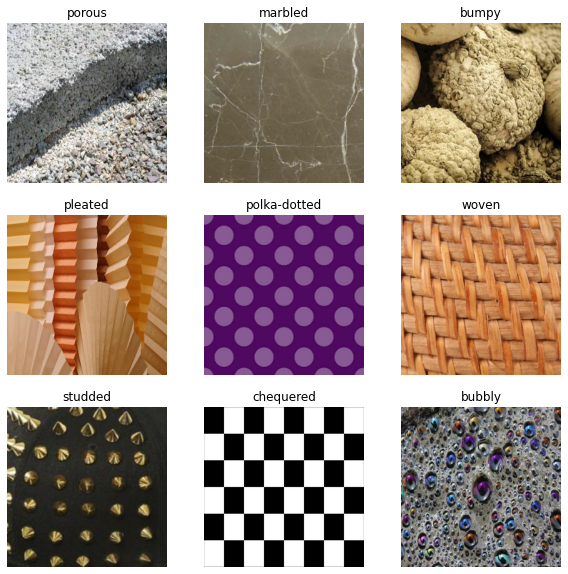

In [ ]:
# vizualize data
class_names = ds_train.class_names
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# preprocessing
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image, label

def preprocess_data(ds_test):
  ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
  #ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
  return ds_test

def batch_data(data, batch_size): # returns a list containg batched data in numpy arrays
  batch_list = [batch_size*(x+1) for x in range(data.shape[0]//batch_size)]
  batched_data = np.split(data, batch_list)
  return batched_data
    
# store image data in ndarrays
def tfds_to_numpy(ds):
  image_features = []
  labels = []
  for img_batches, label_batches in ds:
    image_features.append(img_batches.numpy())
    labels.append(label_batches.numpy())
  return image_features, labels  # returns a numpy array containing unbatched data

ds_train = preprocess_data(ds_train)
train_img_numpy, train_label_numpy = tfds_to_numpy(ds_train)
#print("Number of training batches: ", len(train_img_numpy))
print("shape of data: ", train_img_numpy[1].shape)

shape of data:  (32, 256, 256, 3)


In [ ]:
# feature extraction model
feature_extractor = tf.keras.applications.VGG19(weights = 'imagenet', include_top=False, classes=47)
feature_extractor.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
# feature extraction
def feature_extraction(model, ds_list, extracted_features = [], unbatched = False, batch_size=16):
  if unbatched:
    for index, img_batch in enumerate(ds_list):
      print(f"Calculating features for batch {index+1}/{len(ds_list)}...")
      extracted_features.append(model.predict(img_batch))
  else:
    extracted_features = model.predict(ds_list, batch_size=batch_size)

  return extracted_features

extracted_features = feature_extraction(feature_extractor, train_img_numpy, unbatched=True)

Calculating features for batch 1/124...
Calculating features for batch 2/124...
Calculating features for batch 3/124...
Calculating features for batch 4/124...
Calculating features for batch 5/124...
Calculating features for batch 6/124...
Calculating features for batch 7/124...
Calculating features for batch 8/124...
Calculating features for batch 9/124...
Calculating features for batch 10/124...
Calculating features for batch 11/124...
Calculating features for batch 12/124...
Calculating features for batch 13/124...
Calculating features for batch 14/124...
Calculating features for batch 15/124...
Calculating features for batch 16/124...
Calculating features for batch 17/124...
Calculating features for batch 18/124...
Calculating features for batch 19/124...
Calculating features for batch 20/124...
Calculating features for batch 21/124...
Calculating features for batch 22/124...
Calculating features for batch 23/124...
Calculating features for batch 24/124...
Calculating features for 

In [ ]:
# check the shape of batches
print("shape of feature batches: ", extracted_features[1].shape)

shape of feature batches:  (32, 8, 8, 512)


In [ ]:
# FV extraction
# input data should have shape (n_images, n_descriptors_per_image, n_dim_descriptor)
def train_gmm(features, n_kernels=32):
  features = np.concatenate(features, axis=0)
  i, j, k, m = features.shape
  features = np.reshape(features, (i, m, j*k))
  fv_gmm = fishervector.FisherVectorGMM(n_kernels=n_kernels).fit(features)
  return fv_gmm

# get fisher vector encoding
def get_fv_encodings(fv_gmm, features, batch_size=16):
  fv_encoding = []
  #bc = batch_data(features, batch_size=batch_size)
  for batch in features:
    i, j, k, m = batch.shape
    batch = np.reshape(batch, (i, m, j*k))
    fv_encoding.append(fv_gmm.predict(batch))
  return fv_encoding

fv_gmm = train_gmm(extracted_features, n_kernels = 64)
fv_encodings = get_fv_encodings(fv_gmm, extracted_features)
print("shape of fv_encoding: ", fv_encodings.shape)

KeyboardInterrupt: ignored

In [ ]:
# train an classfier
def classifier(input_shape):
  # initiat input layer
  _, img_width, img_height = input_shape
  input = tf.keras.layers.Input(shape=(img_width, img_height))
  x = tf.keras.layers.Flatten()(input)
  #x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  #x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dense(47, activation='softmax')(x)
  model = tf.keras.Model(inputs=input, outputs=x)
  return model

classifier = classifier(fv_encodings.shape)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 64)]          0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 47)                12079     
                                                                 
Total params: 2,372,655
Trainable params: 2,372,655
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ds_val = preprocess_data(ds_val)
val_img_numpy, val_label_numpy = tfds_to_numpy(ds_val)
val_encodings = feature_extraction(feature_extractor, val_img_numpy)
val_encodings = get_fv_encodings(fv_gmm,val_encodings)

In [ ]:
classifier.compile(optimizer = tf.keras.optimizers.Adam(),
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy','sparse_categorical_crossentropy'])


history = classifier.fit(fv_encodings,train_label_numpy, epochs=25, batch_size=16, verbose=2, validation_data=(val_encodings,val_label_numpy),validation_batch_size=16)